In [1]:
# IMPORTS

%pylab inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from smile.log import log2dl
from smile.log import log2csv

from datetime import datetime
from dateutil import tz


Populating the interactive namespace from numpy and matplotlib


In [2]:
# ENTER SLOG INFO HERE

slog_dirs = ['subj001_JoR/', 'subj002_JoR/', 'subj003_JoR/', 'newJoRtest1/', 'newJoRtest2/']
slog_versions = ['v1', 'v1', 'v1', 'v3', 'v3']
slog_name = 'log_JoR_0.slog'

# Set the date of testing for each subject
test_dates_strings = ['20170803', '20170731', '20170801', '20170822', '20170822']

In [3]:
# SEABORN SETTINGS

sns.set_style(style='darkgrid')
sns.set(font_scale=2)
figsize=[20, 5]

In [4]:
# Create dataframes from slogs, and put them into a list of dataframes. This way, we can
# perform all the analyses for different subject in parallel and compare them.

dataframes = []
for slog_dir in slog_dirs:
    df = pd.DataFrame(log2dl(slog_dir + slog_name))  # Makes the slog into a dataframe
    dataframes.append(df)

In [5]:
# Show the first 5 records of one of the dataframes.

dataframes[0].head()

,base,block,correct,date1,date2,img1,img2,log_num,log_time,oddGapClass,...,press_error,press_time,pulse_off_error,pulse_off_time,pulse_on_error,pulse_on_time,resp,rt,trial_absolute,trial_inBlock
0,262275.575896,1,True,20170620,20170619,images/subj001_day9/morning/https_--userhome-a...,images/subj001_day8/morning/https_--userhome-a...,0,262278.337646,False,...,0.000206,262278.337646,0.000013,262263.838725,0.000011,262263.828593,J,2.761749,1,1
1,262290.109061,1,True,20170626,20170629,images/subj001_day15/morning/https_--userhome-...,images/subj001_day18/morning/https_--userhome-...,0,262290.819062,False,...,0.000199,262290.819062,0.000012,262278.360075,0.000009,262278.341228,J,0.710001,2,2
2,262301.408929,1,False,20170701,20170701,images/subj001_day20/afternoon/https_--userhom...,images/subj001_day20/morning/https_--userhome-...,0,262302.644405,False,...,0.000198,262302.644405,0.000011,262290.843253,0.000009,262290.822484,F,1.235476,3,3
3,262313.108786,1,False,20170702,20170701,images/subj001_day21/afternoon/https_--userhom...,images/subj001_day20/morning/https_--userhome-...,0,262316.104073,False,...,NaN,NaN,0.000013,262302.659757,0.000009,262302.647854,,NaN,4,4
4,262326.325297,1,False,20170618,20170615,images/subj001_day7/afternoon/https_--userhome...,images/subj001_day4/morning/https_--userhome-a...,0,262326.919632,False,...,0.000199,262326.919632,0.000012,262316.126242,0.000009,262316.106999,F,0.594335,5,5


# Corrections

There are bugs in v1 of the JoR. We fix them here.

In [6]:
# The 'correct' field is inverted in the script; fix it (True==False and vice-versa).

for i in range(len(slog_dirs)):
    if slog_versions[i] == 'v1':
        df = dataframes[i]

        corrects_fixed = []

        for j in range(len(df['trial_absolute'])):

            correct_original = df['correct'][j]
            correct_fixed = not correct_original

            corrects_fixed.append(correct_fixed)

        df['correct'] = pd.Series(corrects_fixed, index=df.index)

# Dataframe elaboration

Here we derive a number of new dataframe columns from the original information.

In [7]:
# First define utility functions.

def convert_to_est(datetime_, starting_timezone, date_format):
    # Timezone converter, since Unforgettable.me datetimes are in Zulu time.
        
    # Timezones:
    from_zone = tz.gettz(starting_timezone)
    to_zone = tz.gettz('America/New_York')

    # utc = datetime.utcnow()
    utc = datetime.strptime(datetime_, date_format)

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone.
    eastern = utc.astimezone(to_zone)
    
    return eastern


In [8]:
# Get test dates (supplied above) as proper EST-corrected datetime objects.

test_dates = []

for test_date_string in test_dates_strings:
    est = convert_to_est(test_date_string, 'America/New_York', '%Y%m%d')
    test_dates.append(est)
    

In [9]:
# For every subject's dataframe,
for i in range(len(slog_dirs)):
    df = dataframes[i]
    
    # Add a column representing:
    
    # The time-gaps, in whole days, between the images.
    day_gaps = []
    # The coarser time-gap categories.
    gap_classes = []
    # The average of the times, in whole days, between the test day and each of the images.
    recencies = []
    # The recency discretized into one of three equal classes (0, 1, or 2, with 0 being the most
    # recent third of the subject's stimuli). This is not really a "condition" as we didn't set
    # up the dataframe to choose recency in a class-based manner, but just chose the starting
    # point randomly - still, it's an important post-hoc piece of info.
    recency_classes = []
    # The presentation order of the images within the pair (forward or reverse).
    orders = []
    # The combination of 3 condition classes.
    conditions = []

    # For every trial within the subject's dataframe,
    for j in range(len(df['trial_absolute'])):
        
        # Get EST datetimes from substrings of the image filenames.        
        img1 = df['img1'][j]
        img2 = df['img2'][j]
        datetime1 = img1[img1.index('Z')-14:img1.index('Z')]
        datetime2 = img2[img2.index('Z')-14:img2.index('Z')]
        eastern1 = convert_to_est(datetime1, 'UTC', '%Y%m%d%H%M%S')
        eastern2 = convert_to_est(datetime2, 'UTC', '%Y%m%d%H%M%S')
    
        # Calculate, and classify, the time-gap.
        gap = abs(eastern1 - eastern2).days
        if gap == 0:
            gap_class = '0'
        elif gap in range(1, 3):
            gap_class = '1to2'
        elif gap in range(4, 7):
            gap_class = '4to6'
        elif gap in range(8, 13):
            gap_class = '8to12'
        elif gap == 7:
            gap_class = '7'
        else:
            gap_class = 'other'
            
        # Classify the presentation order.
        if eastern1 < eastern2:
            most_recent_date = eastern2
            most_remote_date = eastern1
            order = 'forward'
        else:
            most_recent_date = eastern1
            most_remote_date = eastern2
            order = 'reverse'
            
        # Calculate the recency.
        recency = ((test_dates[i] - most_recent_date).days + (test_dates[i] - most_remote_date).days)/2
            
        # Append info to the appropriate list.
        day_gaps.append(gap)
        gap_classes.append(gap_class)
        recencies.append(recency)           
        orders.append(order)

    # Convert the lists to dataframe columns.
    df['gap'] = pd.Series(day_gaps, index=df.index)
    df['gap_class'] = pd.Series(gap_classes, index=df.index)
    df['recency'] = pd.Series(recencies, index=df.index)
    df['order'] = pd.Series(orders, index=df.index)
    
    
    # For each trial within the subject, classify the recency and add the resulting list as a dataframe column.
    recency_min = min(recencies)
    recency_max = max(recencies)+1
    recency_span = recency_max - recency_min
    
    for j in range(len(df['trial_absolute'])):
        recency_class = str(int(floor(3*((float(recencies[j]) - float(recency_min)) / float(recency_span)))))
        recency_classes.append(recency_class)
    
    df['recency_class'] = pd.Series(recency_classes, index=df.index)
    
    
    # For each trial within the subject, construct a "metaclass" combining gap, recency and order classes.
    # This will be used to assess balance across conditions. Add the resulting list as a dataframe column.
    for j in range(len(df['trial_absolute'])):
        gap_class = df['gap_class'][j]
        recency_class = df['recency_class'][j]
        order = df['order'][j]

        condition = gap_class + '/' + recency_class + '/' + order

        conditions.append(condition)

    df['condition'] = pd.Series(conditions, index=df.index)

<br><br><br><br><br><br><br><br>

# Validating the conditions

In all of the following sets of plots, the first 3 are real subjects 001, 002, and 003, who were run on v1 of the listgen. The last 2 plots are tests of the v3 listgen, which gets rid of a number of bugs in v1.

### Between-image time gap, both absolute and by "class"

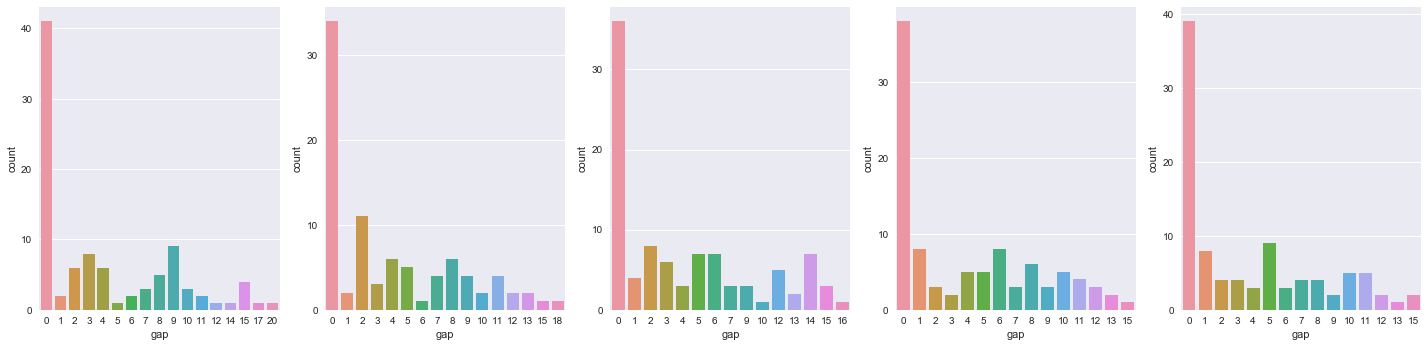

In [10]:
sns.set(font_scale=1)

fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='gap', ax=axs[i])
    
fig.tight_layout()

sns.set(font_scale=2)

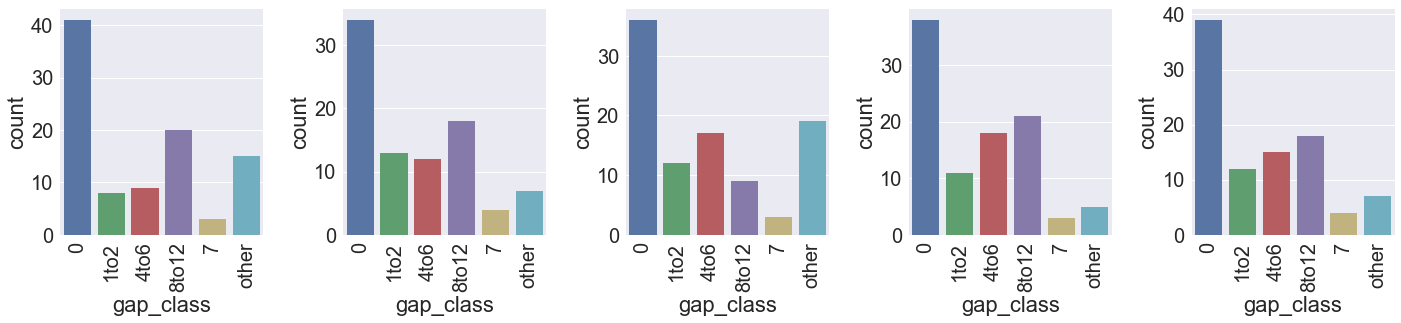

In [11]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='gap_class', order=['0', '1to2', '4to6', '8to12', '7', 'other'], ax=axs[i])
    
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    
fig.tight_layout()

Overall, balance is ok but not great, with a slight improvement from v1 to v3.
<br><br>
The "0" (or same-day) condition is supposed to have twice as many instances as the other conditions because it actually divides up into subclasses that aren't shown here. 1to2, 4to6 and 8to12 are supposed to be even, and half the representation of 0.
<br><br>
7 was the "sacrificial lamb". It seems that it's a difficult thing to depletively draw all of these classes, and the last-drawn class that is constrained by how big the gap has to be may come up short, just not having enough remaining stimuli that are the right temporal distance apart. The "other" class picks up the remaining pieces and assembles them into pairs regardless of their gap, so it represents the leftovers of the 7 class. (There are also probably some "other" stimuli that just happened to fall into one of the other groups and count toward the height of those bars).

### Recency (how long ago did the images happen), both absolute and by evenly-divided "classes"

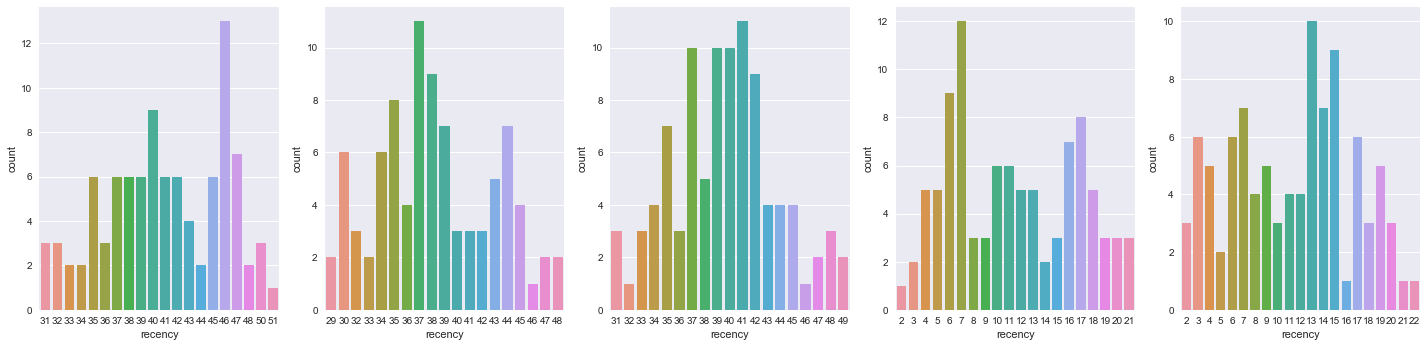

In [13]:
sns.set(font_scale=1)

fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='recency', ax=axs[i])
    
fig.tight_layout()

sns.set(font_scale=2)

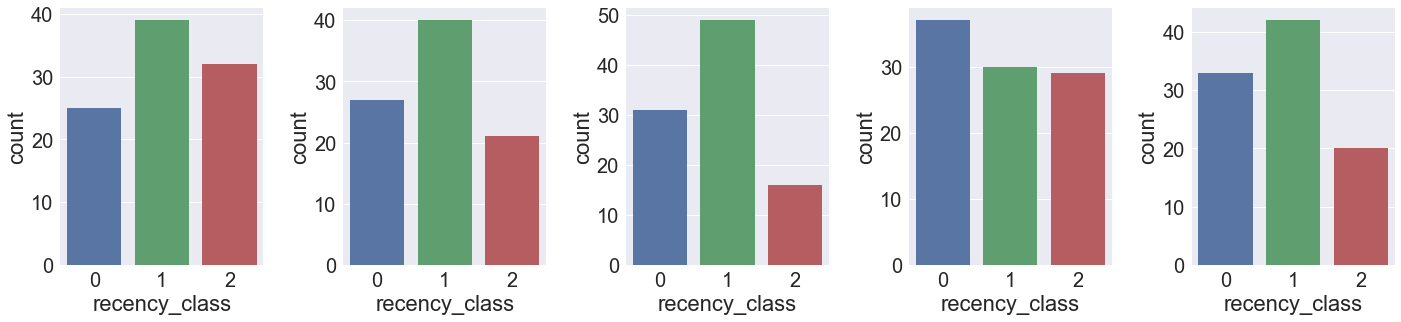

In [14]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='recency_class', ax=axs[i])
    
fig.tight_layout()

Recency isn't a real class implemented in the listgen, but is calculated post-hoc. It's clear that there's a central tendency in the recency across both listgen versions - not surprising, given edge effects (a candidate pair of stimulus dates will be rejected if one of the dates goes beyond the ~21-day bounds of the collection period).

### Order (whether the first image in real time was actually presented first in the experiment)

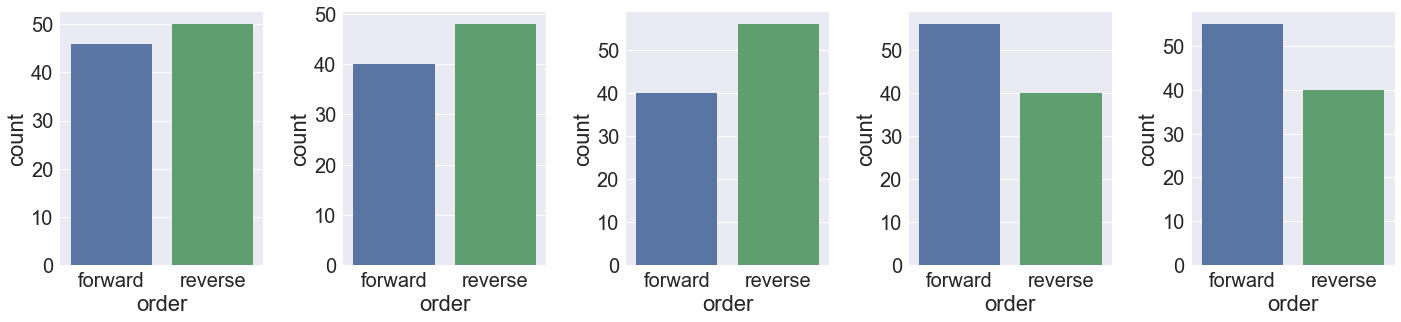

In [15]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='order', order=['forward', 'reverse'], ax=axs[i])
    
fig.tight_layout()

There is more randomness in the forward-reverse order than expected. *These are supposed to be exactly counterbalanced by the listgen.* My current guess is that this failure is happening when the stimuli for time-gap "7" are collected. That is the gap class that always comes up short, and that means it may end with an uneven number of forward/reverse order pairs, since a time-gap class must be collected in full to guarantee even representation of the two orders within its stimuli.

# Global balance of conditions

Did the stimuli sort out evenly across the 36 "meta" conditions (6 gap classes x 3 recency classes x 2 order classes?)

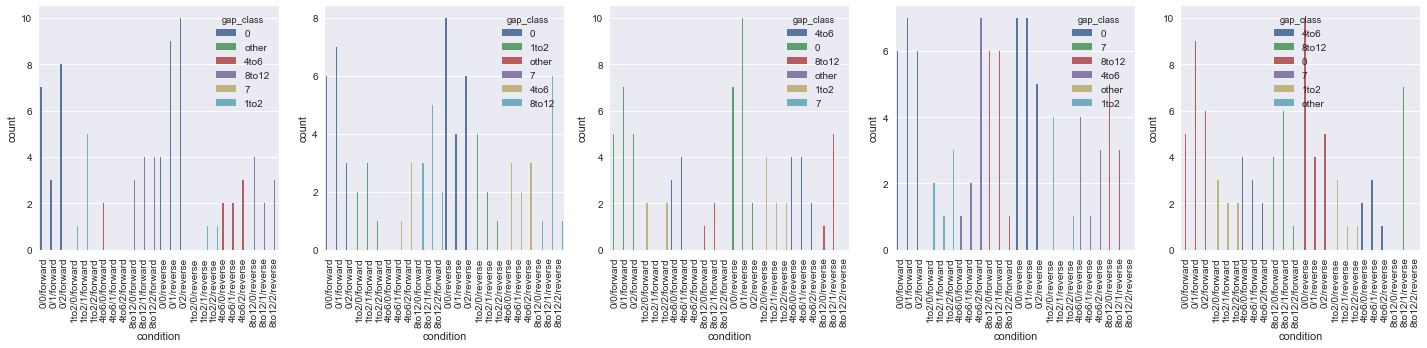

In [16]:
sns.set(font_scale=1)

fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

# I am excluding the "7" and "odd" timegap-classes, since they are expected to be under-represented and variable.
# This way we can better focus on whether the core timegap-classes (0, 1to2, 4to6, 8to12) combine well with
# recency and order classes.

order = ['0/0/forward', '0/1/forward', '0/2/forward', '1to2/0/forward', '1to2/1/forward', '1to2/2/forward',
         '4to6/0/forward', '4to6/1/forward', '4to6/2/forward', '8to12/0/forward', '8to12/1/forward', '8to12/2/forward',
         #'7/0/forward', '7/1/forward', '7/2/forward', 'other/0/forward', 'other/1/forward', 'other/2/forward',
         '0/0/reverse', '0/1/reverse', '0/2/reverse', '1to2/0/reverse', '1to2/1/reverse', '1to2/2/reverse',
         '4to6/0/reverse', '4to6/1/reverse', '4to6/2/reverse', '8to12/0/reverse', '8to12/1/reverse', '8to12/2/reverse',
         #'7/0/reverse', '7/1/reverse', '7/2/reverse', 'other/0/reverse', 'other/1/reverse', 'other/2/reverse',
         ]

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='condition', hue='gap_class', order = order, ax=axs[i])
    #plot = sns.countplot(data=dataframes[i], x='condition', ax=axs[i])
    
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    
fig.tight_layout()

sns.set(font_scale=2)

The above plots are hard to read, so let me break them down:
<br><br>
In each of these runs, there is a fair correspondence between trials in forward order (left half of plot) and trials in reverse order (right half of graph).<br>
In all versions, there is a ~2x overrepresentation of "0" time-gaps (the first 3 bars on each half of the plot). This is as expected, since the same-day condition actually breaks down into 2 subclasses (same half-day, same full day).<br>
Everything else is way off-balance. Representation is not close to even or center-biased (as we would expect) across recencies within each order/time-gap combination. The 1to2, 4to6, and 8to12 time-gaps are not even with each other. Many combinations of gap/recency/order have no representation at all.

# Summary as of 2017/08/26:

There's something fundamentally wrong with the listgen which has not yet been fixed.
<br><br>
Major changes from v1 to v3, which did not fix the problem, include:
 - Correction to a variable-naming convention that obscured a flaw in the conditinal logic supporting the "order" condition.
 - Sorting the original glob of subject folders by name.
 - Forcing left-zero-padded day names on the subject folders.
 - Overall refactoring, variable consolidation, and reformatting for PEP-8 compliance in order to increase the clarity of script flow.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
--------------------- BELOW THIS LINE, WIP, UNFINISHED WORK! --------------------------

<br><br><br><br><br><br><br><br>

# Basic characterization

Let's first look at the responses themselves, and how they relate to RTs.

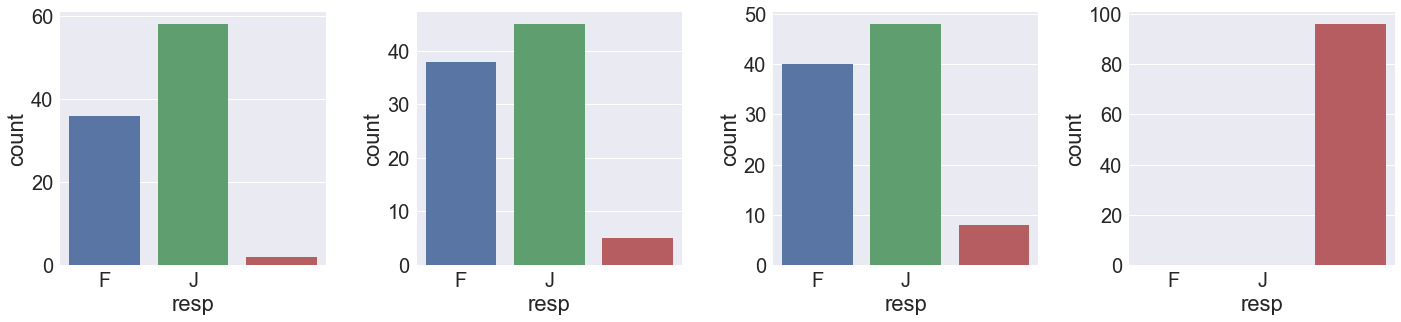

In [52]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='resp', order=['F', 'J', ''], ax=axs[i])
    
fig.tight_layout()

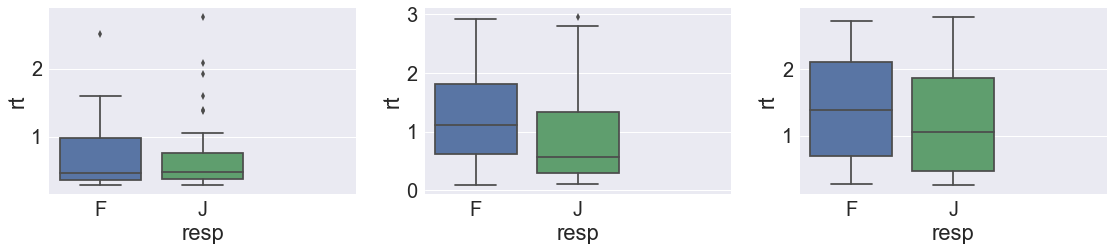

In [14]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.boxplot(data=dataframes[i], x='resp', y='rt', order=['F', 'J', ''], ax=axs[i])
    
fig.tight_layout()

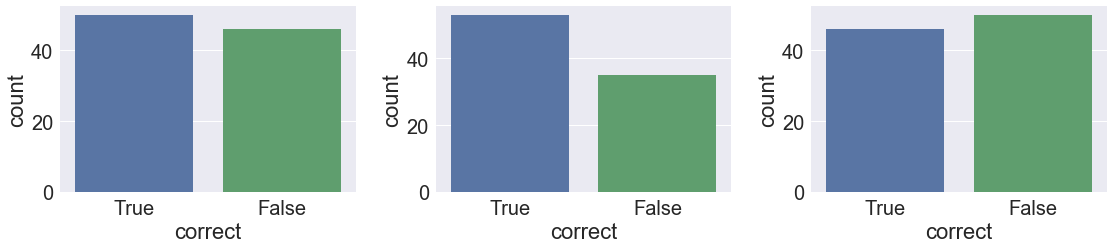

In [15]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.countplot(data=dataframes[i], x='correct', order=[True, False], ax=axs[i])
    
fig.tight_layout()



# Session time

Now let's see if reaction time changes over the length of the session.

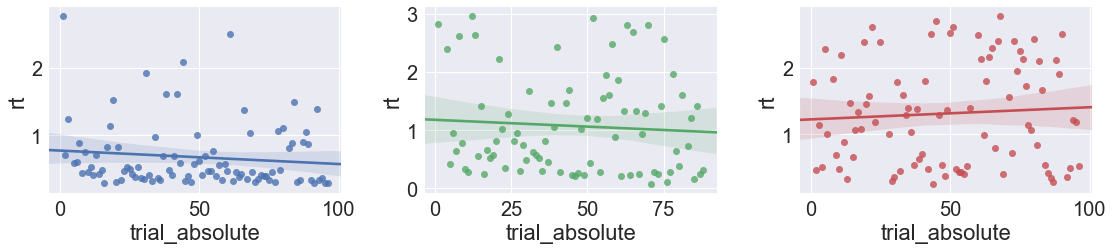

In [23]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    plot = sns.regplot(data=dataframes[i], x='trial_absolute', y='rt', ax=axs[i])
    
fig.tight_layout()


# Recency versus memory

Does a more remote recency correspond to worse recall?

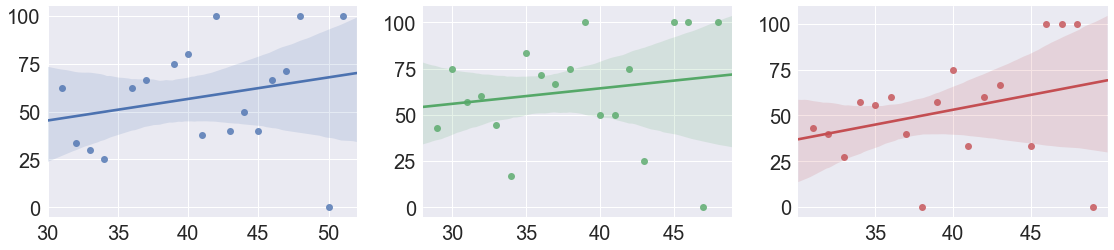

In [55]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    df = dataframes[i]
    
    recencies = range(28, 52)
    
    correct_percents_by_recency = {}

    for recency in recencies:
        correct_number = ((df['correct'] == True) & (df['recency'] == recency)).sum()
        total_number = (df['recency'] == recency).sum()
        if total_number != 0:
            correct_percent = 100*float(correct_number)/float(total_number)
            correct_percents_by_recency.update({recency: correct_percent})

    recencies_for_subj = []
    correct_percents_list = []
    for key in recencies:
        if key in correct_percents_by_recency:
            recencies_for_subj.append(key)
            correct_percents_list.append(correct_percents_by_recency[key])

    # Bug in regplot won't take lists, so convert data to arrays
    xArray = np.array(recencies_for_subj)
    yArray = np.array(correct_percents_list)
    plot = sns.regplot(x=xArray, y=yArray, ax=axs[i])
    
fig.tight_layout()

Oddly, the longer ago the event, the better its time was recalled... but, there may be a correlation, due to the way we selected, between recency and gap. The smaller the recency, the more time available there is for the selection of large gaps. That means that smaller recencies should be associated with better memory... it doesn't track.

# Gap timescale versus memory

Do longer timescales correspond to worse recall?

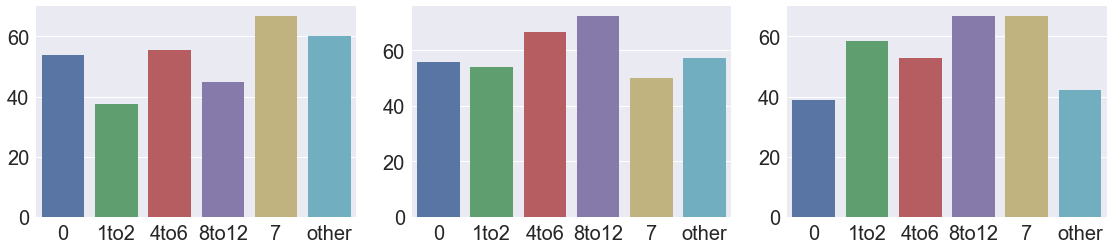

In [56]:
gap_class_names = ['0', '1to2', '4to6', '8to12', '7', 'other']


fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    df = dataframes[i]
    
    correct_percents_by_gap_class = {}

    for gap_class_name in gap_class_names:
        correct_number = ((df['correct'] == True) & (df['gap_class'] == gap_class_name)).sum()
        total_number = (df['gap_class'] == gap_class_name).sum()
        correct_percent = 100*float(correct_number)/float(total_number)
        correct_percents_by_gap_class.update({gap_class_name: correct_percent})

    correct_percents_list = []
    for key in gap_class_names:
        correct_percents_list.append(correct_percents_by_gap_class[key])

    plot = sns.barplot(x=gap_class_names, y=correct_percents_list, ax=axs[i])
    
fig.tight_layout()

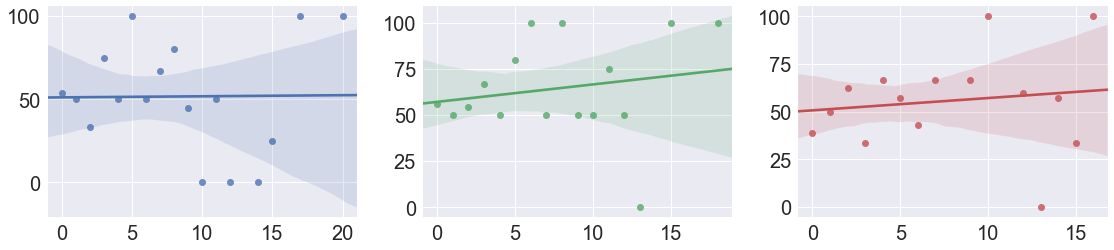

In [57]:
fig, axs = plt.subplots(ncols=len(slog_dirs), figsize=figsize)

for i in range(len(slog_dirs)):
    df = dataframes[i]
    
    gaps = range(0, 21)
    
    correct_percents_by_gap = {}

    for gap in gaps:
        correct_number = ((df['correct'] == True) & (df['gap'] == gap)).sum()
        total_number = (df['gap'] == gap).sum()
        if total_number != 0:
            correct_percent = 100*float(correct_number)/float(total_number)
            correct_percents_by_gap.update({gap: correct_percent})

    gaps_for_subj = []
    correct_percents_list = []
    for key in gaps:
        if key in correct_percents_by_gap:
            gaps_for_subj.append(key)
            correct_percents_list.append(correct_percents_by_gap[key])

    # Bug in regplot won't take lists, so convert data to arrays
    xArray = np.array(gaps_for_subj)
    yArray = np.array(correct_percents_list)
    plot = sns.regplot(x=xArray, y=yArray, ax=axs[i])
    
fig.tight_layout()

This makes sense - the more space there is between images, the easier it is to remember which came first.

# To do:

* Learn to use regression tools.
* Investigate if there is a joint effect of gap and recency.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>




# Loose code below:

In [ ]:
sns.set_style(style='darkgrid')
sns.set(font_scale=2)

def r2(x, y):
    return scipy.stats.pearsonr(x, y)[0] ** 2

plot = sns.jointplot(data=df,
                      x='compositeMetric',
                      y='avg_score_across_all_trials',
                      size=7, kind='reg')
plot.set_axis_labels('AUDIT/BIS-11/GABS composite score', 'Earlyness/lateness')




#df.to_csv('spreadsheet.csv')

#df.head()  # Show the first 5 records of the dataframe

#df['trial_num_block'][0:32]  # Show records x to y of the dataframe (remember these are indices, so they start at 0)

#df['column'][x]  # Show xth record's entry in the specific field "column"

#df.to_csv('spreadsheetname.csv')  # Save out the dataframe as a csv spreadhseet

#df2 = pd.read('spreadsheetname.csv')  # Read a csv spreadsheet back into a dataframe